# Missing data use case

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from raking.experimental import  DataBuilder , DualSolver, PrimalSolver

pd.set_option('mode.chained_assignment', None)

Load the data and get theam at the right format.

In [3]:
observations = pd.read_csv('/Users/ducela/Documents/Raking/perso/Raking_paper/methods/observations.csv')
margins = pd.read_csv('/Users/ducela/Documents/Raking/perso/Raking_paper/methods/margins.csv')

observations['weights'] = np.where( \
    observations['value'].isna(), 0.0, 1.0)

margins['race'] = 0
margins['county'] = 0
margins = margins.loc[margins.cause!='_all']
margins.rename(columns={'value_agg_over_race_county': 'value'}, inplace=True)
margins['weights'] = np.inf

df = pd.concat([ \
    observations[['value', 'cause', 'race', 'county', 'weights']], \
    margins[['value', 'cause', 'race', 'county', 'weights']]])

Rake initial dataset.

In [8]:
data_builder = DataBuilder(
    dim_specs={'cause': '_all', 'race': 0, 'county': 0},
    value='value',
    weights='weights',
)
data = data_builder.build(df)

solver = DualSolver(distance='entropic', data=data)
soln = solver.solve()

/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental/data.py:231: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_i_to_j = pd.concat(


ValueError: operands could not be broadcast together with shapes (93,) (92,) 

Remove the rows with missing data and rake.

In [9]:
df2 = df.copy(deep=True).dropna()

data_builder = DataBuilder(
    dim_specs={'cause': '_all', 'race': 0, 'county': 0},
    value='value',
    weights='weights',
)
data2 = data_builder.build(df2)

solver2 = DualSolver(distance='entropic', data=data2)
soln2 = solver2.solve()

/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental/data.py:231: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_i_to_j = pd.concat(


Compute the margins.

In [16]:
sum_over_cause = soln2.groupby(['race', 'county']).agg({'soln': 'sum'}).reset_index()
sum_over_cause['cause'] = '_all'

sum_over_race = soln2.groupby(['cause', 'county']).agg({'soln': 'sum'}).reset_index()
sum_over_race['race'] = 0

sum_over_cause_race = soln2.groupby(['county']).agg({'soln': 'sum'}).reset_index()
sum_over_cause_race['cause'] = '_all'
sum_over_cause_race['race'] = 0

sum_over_race_county = soln2.groupby(['cause']).agg({'soln': 'sum'}).reset_index()
sum_over_race_county['race'] = 0
sum_over_race_county['county'] = 0

result = pd.concat([soln2, sum_over_cause, sum_over_race, sum_over_cause_race, sum_over_race_county]). \
    merge(df, how='inner', on=['cause', 'race', 'county'])

Check if the margins are respected.

In [23]:
np.allclose(result.loc[(result.race==0)&(result.county==0)].value.to_numpy(), \
            result.loc[(result.race==0)&(result.county==0)].soln.to_numpy())

True

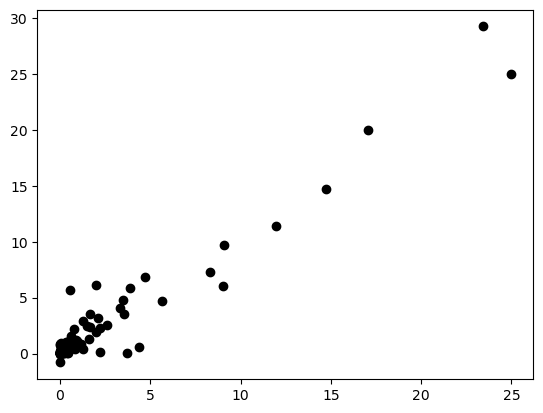

In [25]:
plt.plot(result.value.to_numpy(), result.soln.to_numpy(), 'ko')

Impute some data where they are missing to avoid having an entire row of missing data.

In [49]:
df3 = df.copy(deep=True)
df3.loc[60, 'value'] = result.loc[(result.race==3)&(result.county==533)&(result.cause=='_all')].soln.iloc[0]
df3.loc[61, 'value'] = result.loc[(result.race==3)&(result.county==533)&(result.cause=='_comm')].soln.iloc[0]
df3.loc[62, 'value'] = result.loc[(result.race==3)&(result.county==533)&(result.cause=='_inj')].soln.iloc[0]

data_builder = DataBuilder(
    dim_specs={'cause': '_all', 'race': 0, 'county': 0},
    value='value',
    weights='weights',
)
data3 = data_builder.build(df3)

solver3 = DualSolver(distance='entropic', data=data3)
soln3 = solver3.solve()

/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental/data.py:231: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_i_to_j = pd.concat(


ValueError: operands could not be broadcast together with shapes (93,) (92,) 